# Image segmentation with a U-Net-like architecture

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/03/20<br>
**Last modified:** 2020/04/20<br>
**Description:** Image segmentation model trained from scratch on the Oxford Pets dataset.

## Prepare paths of input images and target segmentation masks

In [1]:
import os
import time

input_folder = "stream_dataset"

input_dir = os.path.join(input_folder, "images/")
target_dir = os.path.join(input_folder, "labels")
img_size = (256, 256)
num_classes = 2
batch_size = 2

# inputs end with ".JPG"
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".JPG")
    ]
)

# labels end with "_label.png"
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith("_label.png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))
print("Number of labels:", len(target_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 1222
Number of labels: 1222
stream_dataset/images/S-1_D021120_021820_47_I11_NE_L4.JPG | stream_dataset/labels/S-1_D021120_021820_47_I11_NE_L4_label.png
stream_dataset/images/S-1_D021120_021820_47_I18_NE_L4.JPG | stream_dataset/labels/S-1_D021120_021820_47_I18_NE_L4_label.png
stream_dataset/images/S-1_D021120_021820_47_I48_NE_L4.JPG | stream_dataset/labels/S-1_D021120_021820_47_I48_NE_L4_label.png
stream_dataset/images/S-1_D021120_021820_47_I49_NE_L4.JPG | stream_dataset/labels/S-1_D021120_021820_47_I49_NE_L4_label.png
stream_dataset/images/S-1_D021120_021820_47_I55_NE_L4.JPG | stream_dataset/labels/S-1_D021120_021820_47_I55_NE_L4_label.png
stream_dataset/images/S-1_D021120_021820_47_I65_NE_L4.JPG | stream_dataset/labels/S-1_D021120_021820_47_I65_NE_L4_label.png
stream_dataset/images/S-1_D061720_072220_49_I107_NE_L3.JPG | stream_dataset/labels/S-1_D061720_072220_49_I107_NE_L3_label.png
stream_dataset/images/S-1_D061720_072220_49_I311_NE_L2.JPG | stream_dataset/labels/

## What does one input image and corresponding segmentation mask look like?

2025-10-10 13:52:22.701961: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-10 13:52:22.710841: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760118742.721045  477706 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760118742.724050  477706 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760118742.731722  477706 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

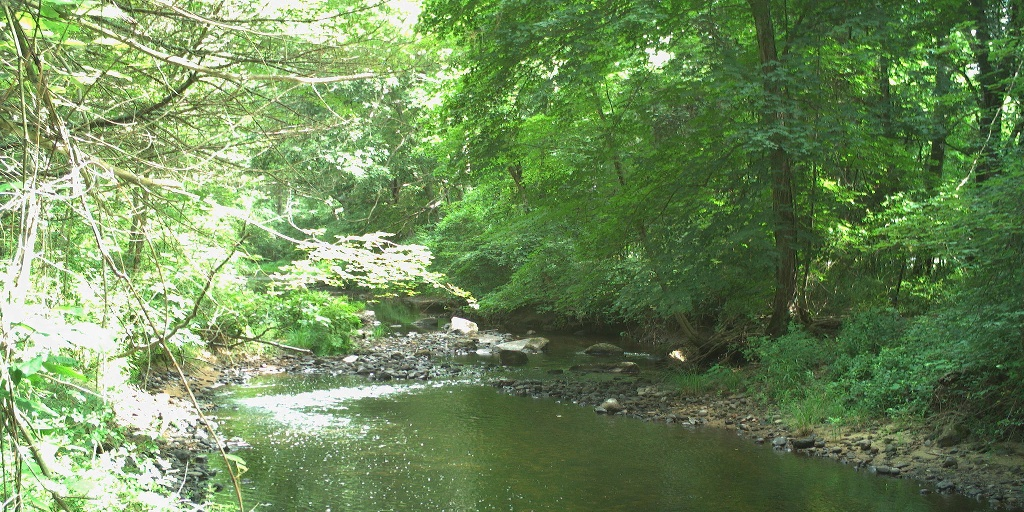

stream_dataset/images/S-1_D062420_081920_60_I232_NE_L4.JPG
stream_dataset/labels/S-1_D062420_081920_60_I232_NE_L4_label.png


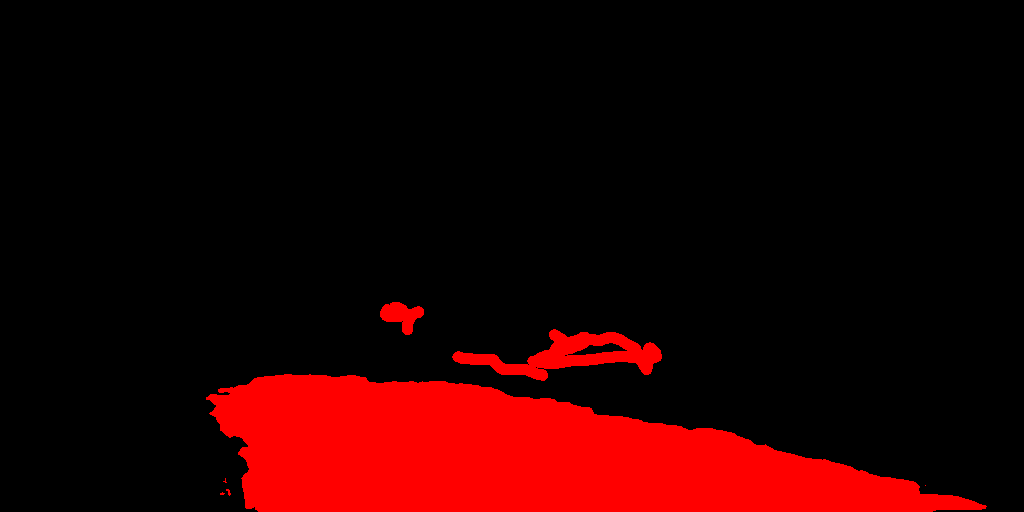

In [2]:
from IPython.display import Image, display
from keras.utils import load_img
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[20]))
print(input_img_paths[20])

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[20]))
print(target_img_paths[20])
display(img)

## Prepare dataset to load & vectorize batches of data

In [3]:
import keras
import numpy as np
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io
import tensorflow as tf

def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""

    def load_img_masks(input_img_path, target_img_path):
        # Load input image
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.convert_image_dtype(input_img, "float32")
        
        # Load target image
        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.convert_image_dtype(target_img, "uint8")
        
        # First resize to maintain aspect ratio, then pad to square
        # Option 1: Resize to fit within square, then pad
        input_img = tf_image.resize_with_pad(input_img, img_size[0], img_size[0])
        target_img = tf_image.resize_with_pad(target_img, img_size[0], img_size[0], method="nearest")
        
        # Process target image
        target_img = tf.where(target_img == 0, 0, 1)
        target_img = tf.cast(target_img, tf.uint8)

        return input_img, target_img

    # For faster debugging, limit the size of data
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)


## Prepare U-Net Xception-style model

In [5]:
from keras import layers

from unet import build_UNET
# Build model
model = build_UNET(img_size, num_classes, [64, 128, 256, 512],3, "eca")
model.summary()

I0000 00:00:1760118793.932949  477706 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1107 MB memory:  -> device: 0, name: NVIDIA RTX 4000 Ada Generation, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "attention_residual_unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        256 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (GroupNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ group_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 256,  │          0 │ conv2d_2[0][0],   │
│                     │ 64)               │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 256, 256,  │        128 │ add[0][0]         │
│ (GroupNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │     36,928 │ group_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256, 256,  │          0 │ conv2d_4[0][0],   │
│                     │ 64)               │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 256, 256,  │        128 │ add_1[0][0]       │
│ (GroupNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 256, 256,  │     36,928 │ group_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256, 256,  │          0 │ conv2d_5[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 256, 256,  │          0 │ conv2d_6[0][0], 

 Total params: 27,514,372 (104.96 MB)

 Trainable params: 27,514,372 (104.96 MB)

 Non-trainable params: 0 (0.00 B)

## Set aside a validation split

In [6]:
import random

# Split our img paths into a training and a validation set
val_samples = 200
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]
print("Training samples:", len(train_input_img_paths))
print("Validation samples:", len(val_input_img_paths))

# Remove the `max_dataset_len` arg when running with full dataset.
train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
    max_dataset_len=1000,
)
valid_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

Training samples: 1022
Validation samples: 200


## Train the model

In [7]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
def iou_metric(y_true, y_pred):
    """Calculate IoU metric for binary segmentation"""
    # Convert predictions to binary (argmax for multi-class)
    y_pred = tf.cast(tf.argmax(y_pred, axis=-1), tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    
    # Flatten tensors
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    # Calculate intersection and union
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    
    # Avoid division by zero
    iou = tf.cond(tf.equal(union, 0), 
                  lambda: 1.0, 
                  lambda: intersection / union)
    
    return iou

model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss= "sparse_categorical_crossentropy", metrics=["accuracy", iou_metric]
)

callbacks = [
    keras.callbacks.ModelCheckpoint("stream_segmentation.keras", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 30
model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=2,
)

Epoch 1/30


I0000 00:00:1760118828.290261  477793 service.cc:152] XLA service 0x77a750014460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760118828.290294  477793 service.cc:160]   StreamExecutor device (0): NVIDIA RTX 4000 Ada Generation, Compute Capability 8.9
2025-10-10 13:53:48.845153: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-10 13:53:50.155833: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1760118831.938086  477793 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-10-10 13:53:53.408462: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_36', 8 bytes spill st

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/research/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/research/anaconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/research/anaconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/home/research/anaconda3/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/research/anaconda3/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/home/research/anaconda3/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once

  File "/home/research/anaconda3/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/research/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/home/research/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/home/research/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/home/research/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/home/research/anaconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/home/research/anaconda3/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/research/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/research/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/research/anaconda3/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/research/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/research/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/research/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_477706/936063309.py", line 35, in <module>

  File "/home/research/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/research/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/home/research/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/home/research/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

Out of memory while trying to allocate 2522660720 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_45245]

## Visualize predictions

In [ ]:
# Generate predictions for all images in the validation set

val_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)
val_preds = model.predict(val_dataset)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 112


# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.